In [1]:
import numpy as np
from scipy.io import mminfo,mmread
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.linalg import eig
from numpy import sqrt, dot, sum, abs, diag, array, pi
from scipy import sparse

Exercise 5 - Numerical Experiment
============================



In [2]:
# load system matrices
M = sparse.csc_matrix(mmread('Ms.mtx'))#.toarray() # mass matrix
K = sparse.csc_matrix(mmread('Ks.mtx'))#.toarray() # stiffness matrix
X = mmread('X.mtx') # coodinate matrix with columns corresponding to x,y,z position of the nodes
C = sparse.csc_matrix(M.shape)
N = X.shape[0] # number of nodes

In [3]:
# for plotting
nprec = 6 # precision for finding uniqe values
# get grid vectors (the unique vectors of the x,y,z coodinate-grid)
xv = np.unique(np.round(X[:,0],decimals=nprec))
yv = np.unique(np.round(X[:,1],decimals=nprec))
zv = np.unique(np.round(X[:,2],decimals=nprec))

In [4]:
# point selection
tol = 1e-12

# select top of the plate
Nt = np.argwhere(np.abs(X[:,2]-X[:,2].max())<tol)[:,0]

# indices of x, y, and z DoFs in the global system
# can be used to get DoF-index in global system, e.g. for y of node n by Iy[n]
Ix = np.arange(N)*3 # index of x-dofs
Iy = np.arange(N)*3+1
Iz = np.arange(N)*3+2

# corner points
Nnoc = np.argwhere(np.all(np.vstack([np.abs(X[:,1]-X[:,1].max())<tol,np.abs(X[:,0]-X[:,0].max())<tol,np.abs(X[:,2])<tol]),axis=0)).ravel()
Nnwc = np.argwhere(np.all(np.vstack([np.abs(X[:,1]-X[:,1].max())<tol,np.abs(X[:,0]-X[:,0].min())<tol,np.abs(X[:,2])<tol]),axis=0)).ravel()
Nsoc = np.argwhere(np.all(np.vstack([np.abs(X[:,1]-X[:,1].min())<tol,np.abs(X[:,0]-X[:,0].max())<tol,np.abs(X[:,2])<tol]),axis=0)).ravel()
Nswc = np.argwhere(np.all(np.vstack([np.abs(X[:,1]-X[:,1].min())<tol,np.abs(X[:,0]-X[:,0].min())<tol,np.abs(X[:,2])<tol]),axis=0)).ravel()

P_01 = [-0.324074, -0.173333, 0]
P_02 = [-0.194444, -0.173333, 0]
P_03 = [-0.064815, -0.173333, 0]
P_04 = [0.064815, -0.173333, 0]
P_05 = [0.194444, -0.173333, 0]
P_06 = [0.324074, -0.173333, 0]
P_07 = [-0.324074, -0.066667, 0]
P_08 = [-0.194444, -0.066667, 0]
P_09 = [-0.064815, -0.066667, 0]
P_10 = [0.064815, -0.066667, 0]
P_11 = [0.194444, -0.066667, 0]
P_12 = [0.324074, -0.066667, 0]
P_13 = [-0.324074, 0.066667, 0]
P_14 = [-0.194444, 0.066667, 0]
P_15 = [-0.064815, 0.066667, 0]
P_16 = [0.064815, 0.066667, 0]
P_17 = [0.194444, 0.066667, 0]
P_18 = [0.324074, 0.066667, 0]
P_19 = [-0.324074, 0.173333, 0]
P_20 = [-0.194444, 0.173333, 0]
P_21 = [-0.064815, 0.173333, 0]
P_22 = [0.064815, 0.173333, 0]
P_23 = [0.194444, 0.173333, 0]
P_24 = [0.324074, 0.173333, 0]


Text(0, 0.5, '$y$ in m')

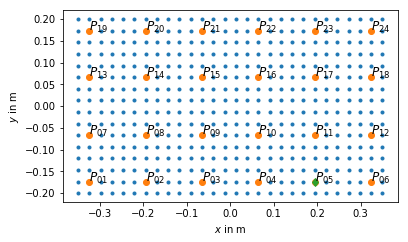

In [5]:
Na = []
i = 0
for yi in yv[[1,5,-6,-2]]:
    for xi in xv[1::5]:
        i += 1
        Pi = [xi,yi,0]
        print('P_%02i = %s'%(i,str(Pi)))
        Ni = np.argmin(np.sum((X-Pi)**2,axis=1))
        Na.append(Ni)
Na = np.array(Na)

fig,ax = plt.subplots()
ax.plot(X[Nt,0],X[Nt,1],'.')
ax.plot(X[Na,0],X[Na,1],'o')
for i,Ni in enumerate(Na):
    ax.annotate('$P_{%02i}$'%(i+1),(X[Ni,0],X[Ni,1]),size=12)

ax.plot(X[Na[4],0],X[Na[4],1],'d')
ax.set_aspect('equal')
ax.set_xlabel('$x$ in m')
ax.set_ylabel('$y$ in m')

## Attach Springs
We attach springs at the corners

In [6]:
E_s = 0.1e+9 # Young's modulus
r_s = 1e-3 # radius
l_s = 1 # length
k_s = r_s**2*pi*E_s/l_s

# Attach springs in x-dirextion and test the plate upright
K_s = sparse.csc_matrix(K.shape)
for Ni in [Nnoc,Nsoc]: # the "top" corners
    # x-direction
    K_s[Ix[Ni],Ix[Ni]] += k_s
    # even softer springs in y and z-direction
    K_s[Iy[Ni],Iy[Ni]] += k_s/2 
    K_s[Iz[Ni],Iz[Ni]] += k_s/2
# one spring at the bottom corner to remove last rigid body mode
K_s[Iz[Nnwc],Iz[Nnwc]] += k_s/10

/share/programs/anaconda/3/latest/lib/python3.6/site-packages/scipy/sparse/compressed.py:746: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


## Compute eigenvalues of un-damped system

In [7]:
from scipy.sparse.linalg import eigsh
Wv,Vv = eigsh(K+K_s,16,M,sigma=0)
#for i in range(m):
#    print(i+1,np.sqrt(Wf[i])/2/pi,np.sqrt(Wv[i])/2/pi,(np.sqrt(Wv[i])/np.sqrt(Wf[i])-1) )
np.sqrt(Wv)/2/pi

array([  0.87101336,   1.01433789,   2.47659637,   2.96871022,
         3.50795842,   3.67453991,  13.86645065,  26.77672458,
        37.78406666,  73.21608207,  83.41795681,  83.57433275,
        87.95861595, 102.94221701, 138.18141507, 145.14237576])

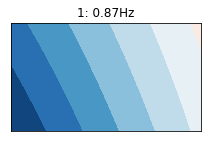

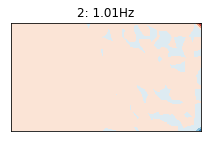

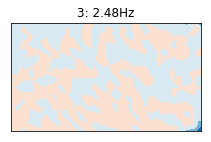

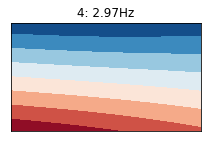

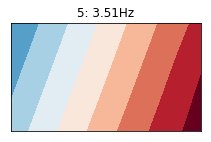

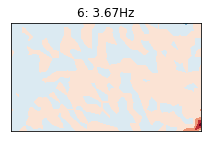

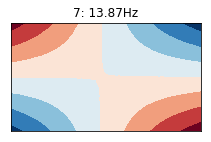

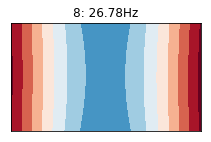

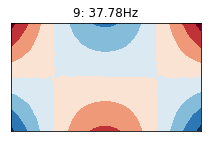

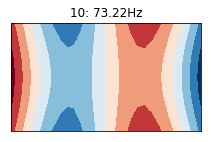

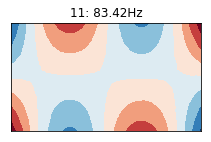

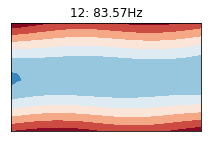

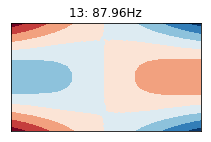

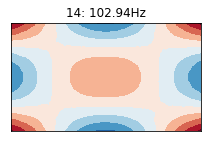

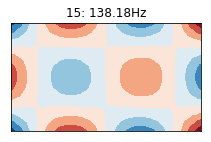

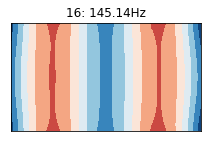

In [9]:
def plotmode2d(v,x,y,lim=None,ax=None) :
    """plots a mode v defined at the points (x,y)"""
    if lim==None:
        lim = np.max(np.abs(v))
    if ax==None:
        fig,ax = plt.subplots(figsize=[3.5,2])
        returns = (fig,ax)
    else :
        returns = ax
    ax.tricontourf(x,y,v,cmap=plt.get_cmap('RdBu_r'),vmin=-lim,vmax=lim)
    ax.set_aspect('equal')
    ax.set_xticks([])
    ax.set_yticks([])
    #fig.tight_layout()
    return returns
for i in range(Vv.shape[1]):
    fig,ax = plotmode2d(Vv[Iz,i],*X[:,:2].T)
    ax.set_title('%i: %.2fHz'%(i+1,np.sqrt(Wv[i])/2/pi))

## Do a Numerical Impact-Hammer Experiemnt

### Determine a Suitable Impact Force

Sampling rate 2000Hz


Text(0.5, 0, 'Frequency in Hz')

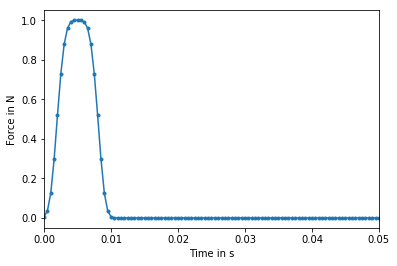

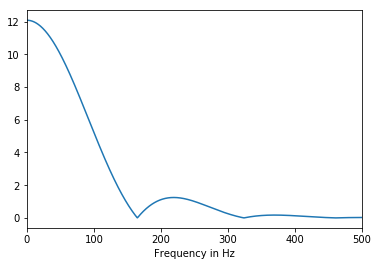

In [10]:
from numpy.fft import rfft, rfftfreq, irfft
dt = 500e-6 #
print('Sampling rate %.0fHz'%(1/dt))
T = 3
n = (int(np.sqrt(T/dt))+1)**2
t = np.arange(0,dt*n,dt)

fig,ax = plt.subplots()
T_hammer = 0.005
f_hammer = np.exp(-(1.5*(t-T_hammer)/T_hammer)**4)
ax.plot(t,f_hammer,'.-') # impulse)
ax.set_xlim(0,10*T_hammer )
ax.set_xlabel('Time in s')
ax.set_ylabel('Force in N')

fig,ax = plt.subplots()
f = rfftfreq(len(t),np.mean(np.diff(t)))
F_hammer = rfft(f_hammer)
ax.plot(f,np.abs(F_hammer))
ax.set_xlim(0,500)
ax.set_xlabel('Frequency in Hz')

/share/programs/anaconda/3/latest/lib/python3.6/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


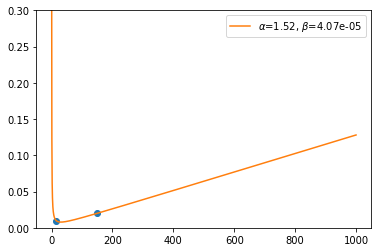

In [11]:
fd = np.array([[15, 150.0]]).T
zd = np.array([0.01, 0.02]).T
#Ad = np.array([])
Ad = np.hstack([1/(2*2*pi*fd),2*pi*fd/2])
alpha,beta = np.linalg.solve(Ad,zd)
#alpha = 2.15 # ab[0,0]
#beta = 3e-5 # ab[1,0]
fig,ax = plt.subplots()
ax.plot(fd,zd,'o')
ax.plot(f,alpha/(2*(2*pi*f))+beta*(2*pi*f)/2,label='$\\alpha$=%.2f, $\\beta$=%.2e'%(alpha,beta))
alpha,beta
ax.legend()
ax.set_ylim(0,.3)
#ax.set_xlim(0,200)
C_rayleigh = alpha*M + beta*(K+K_s)

In [12]:
# Set viscous damping
C_v = sparse.lil_matrix(M.shape)
for i in Iz[Nt]:
    C_v[i,i] = 0.005
C_v = C_v.tocsc()

In [13]:
# force at P_05 
ft = np.zeros([N*3,len(t)])
ft[Iz[Na[4]]] = f_hammer

from utlity_functions import Newmark
xt,vt,at = Newmark(M, C_v+C_rayleigh, K+K_s, ft , t, np.zeros(3*N) )

In [14]:
xtR,vtR,atR = Newmark(M, C_rayleigh, K+K_s, ft , t, np.zeros(3*N) )

In [15]:
xtV,vtV,atV = Newmark(M, C_v, K+K_s, ft , t, np.zeros(3*N) )

Text(0, 0.5, 'Displacement in m')

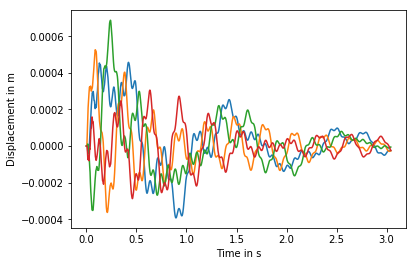

In [16]:
fig,ax = plt.subplots()
ax.plot(t,(xtR[Iz[Na[[0,5,18,23]]],:]).T,'-')
ax.set_xlabel('Time in s')
ax.set_ylabel('Displacement in m')

Text(0, 0.5, 'Displacement in m')

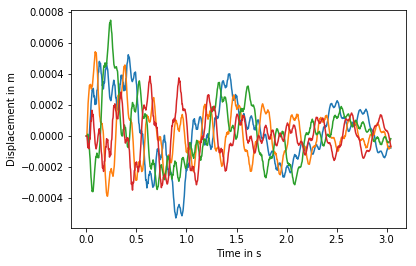

In [17]:
fig,ax = plt.subplots()
ax.plot(t,(xtV[Iz[Na[[0,5,18,23]]],:]).T,'-')
ax.set_xlabel('Time in s')
ax.set_ylabel('Displacement in m')

Text(0, 0.5, 'Displacement in m')

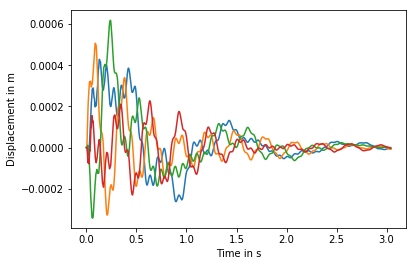

In [18]:
fig,ax = plt.subplots()
ax.plot(t,(xt[Iz[Na[[0,5,18,23]]],:]).T,'-')
ax.set_xlabel('Time in s')
ax.set_ylabel('Displacement in m')

Text(0, 0.5, 'Acceleration in m/s2')

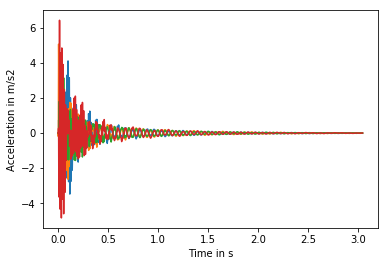

In [19]:
fig,ax = plt.subplots()
ax.plot(t,(at[Iz[Na[[0,5,18,23]]],:]).T,'-')
ax.set_xlabel('Time in s')
ax.set_ylabel('Acceleration in m/s2')

(0, 0.05)

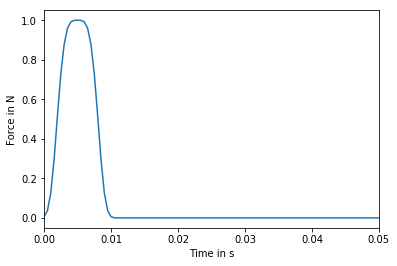

In [22]:
fig,ax = plt.subplots()
ax.plot(t,(f_hammer).T,'-')
#ax.plot(t,xt[Iz[Na[[4]]],:].T,'-k')
ax.set_xlabel('Time in s')
ax.set_ylabel('Force in N')
ax.set_xlim(0,0.05)

In [23]:
# add noise to data and scale (force)
np.random.seed(1001)
xnoise = np.random.normal(scale=0.01*xt.max(),size=len(t))
#vnoise = np.random.normal(scale=0.01*vt.max(),size=len(t))
anoise = np.random.normal(scale=0.005*at.max(),size=[len(Na),len(t)])
fnoise = np.random.normal(scale=0.01*f_hammer.max(),size=len(t))

In [24]:
fac = 50
data = np.vstack([t,fac*(f_hammer+fnoise),fac*(at[Iz[Na],:]+anoise)]).T
np.savetxt('measurement.txt',data,fmt='%12.5e',header=','.join('%12s'%s for s in ['time [s]','f05 [N]']+['a%02i [m/s2]'%(i+1) for i in range(len(Na))]))

In [25]:
data = np.vstack([t,fac*(xt[Iz[Na],:]+xnoise)]).T
np.savetxt('measurement-ITD.txt',data,fmt='%12.5e',header=','.join('%12s'%s for s in ['time [s]']+['x%02i [m/s2]'%(i+1) for i in range(len(Na))]))

In [26]:
np.savetxt('measurement-coordinates.txt',np.vstack([np.arange(len(Na))+1, X[Na,:2].T]).T,fmt=['%8i']+['%8.5f']*2,\
           header=','.join([' Point']+['%8s'%s for s in ['x [m]','y [m]']]))

## Solve the Quadratic EVP

In [27]:
from scipy.sparse.linalg import eigs
m=16
# solve the damped EVP by transforming into first companion form
A = sparse.vstack([ sparse.hstack( [ sparse.csc_matrix((3*N,3*N)) , sparse.csc_matrix(np.diag(np.ones(3*N))) ]),\
        sparse.hstack( [ -(K+K_s) , -C_v-C_rayleigh ] ) ]).tocsc()
B = sparse.vstack([ sparse.hstack( [ sparse.csc_matrix(np.diag(np.ones(3*N))) , sparse.csc_matrix((3*N,3*N)) ]),\
        sparse.hstack( [sparse.csc_matrix((3*N,3*N)) , M ] ) ]).tocsc()

W1,V1 = eigs(A,2*m,B,which='LM',sigma=0)#-1j*2*pi*10)

Text(0, 0.5, 'imag')

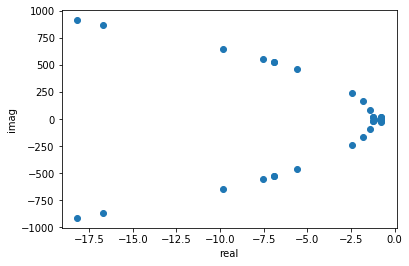

In [28]:
fig,ax = plt.subplots()
ax.plot(W1.real,W1.imag,'o')
ax.set_xlabel('real')
ax.set_ylabel('imag')

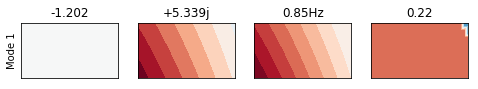

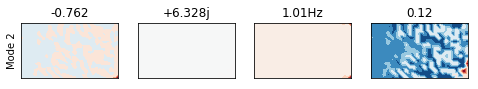

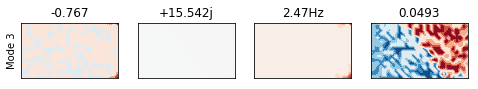

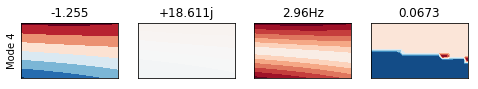

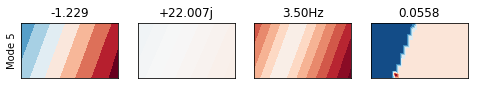

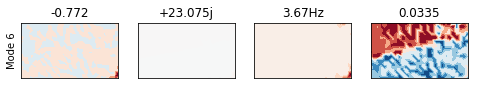

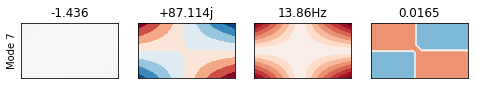

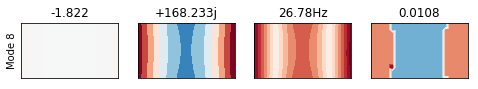

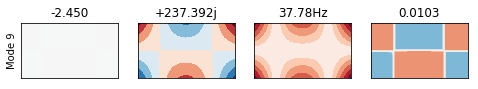

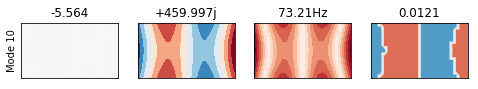

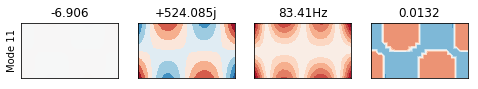

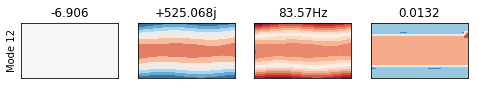

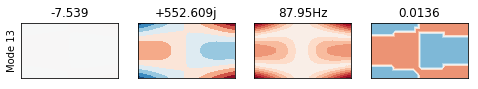

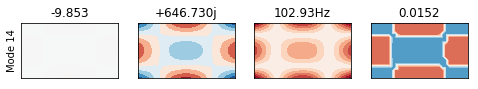

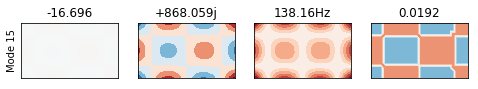

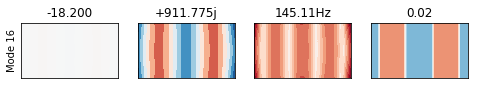

In [29]:
Ip = W1.imag >=0
for n,i in enumerate(np.argwhere(Ip).ravel()):
    fig,axs = plt.subplots(ncols=4,figsize=[8,1.5])
    lim = np.abs(V1[:3*N,i][Iz]).max()
    plotmode2d(V1[:3*N,i][Iz].real,*X[:,:2].T,ax=axs[0],lim=lim)
    plotmode2d(V1[:3*N,i][Iz].imag,*X[:,:2].T,ax=axs[1],lim=lim)
    plotmode2d(np.abs(V1[:3*N,i][Iz]),*X[:,:2].T,ax=axs[2],lim=lim)
    plotmode2d(np.angle(V1[:3*N,i][Iz]),*X[:,:2].T,ax=axs[3],lim=pi)
    r2 = (W1[i].real/W1[i].imag)**2
 
    axs[0].set_title('%+.3f'%W1[i].real)
    axs[1].set_title('%+.3fj'%W1[i].imag)
    axs[2].set_title('%.2fHz'%(W1[i].imag/2/pi))
    axs[3].set_title('%.3g'%(np.sqrt(r2/(1+r2))))
    
    axs[0].set_ylabel('Mode %i'%(n+1))